In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # specify which GPU(s) to be used
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import seaborn as sns
import albumentations  as albu
from albumentations.pytorch import ToTensor
import random

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
from torchvision import models
from torch.autograd import Function

seed = 1234
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
input_dir = ".../data/SSDD/SSDD_local_test_data"
# input_dir_Train  = os.path.join(input_dir, 'trainval_images')
# filelist_Train = os.listdir(input_dir_Train)

input_dir_Test  = os.path.join(input_dir, 'test_images')
filelist_Test = os.listdir(input_dir_Test)

test_df_path = os.path.join(input_dir, 'SSDD_test_data.csv')
test_df = pd.read_csv(test_df_path)
# test_df.head()

def make_df(tdf):
    tdf = tdf.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    tdf['defects'] = tdf.count(axis=1)
    
    return tdf

test_data = make_df(test_df)

# Data Augmentation

In [3]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
def get_augmentation(mean, std, phase):
    
    if phase == 'train':
        transform = [
            albu.HorizontalFlip(p=0.5),
            albu.Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    else:
        transform = [
            albu.Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    
    return albu.Compose(transform)


def make_mask(index, df):
    filename = df.iloc[index].name
    labels = df.iloc[index, :4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32)
    for idx, label in enumerate(labels):
        if label is not np.nan:
            mask = np.zeros((256*1600), dtype=np.uint8)
            pixels = label.split(' ')
            pixels = [pixels[i:i+2] for i in range(0, len(pixels), 2)]
            for pixel in pixels:
                pos, le = pixel
                pos, le = int(pos), int(le)
                mask[pos-1:pos+le-1] = 1
            masks[:,:,idx] = mask.reshape(256, 1600, order = 'F')
            # changed_mask = masks[0:] + 2.*masks[1] + 3.*masks[2] + 4.*masks[3]
    return filename, masks

# Dataloader

In [4]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, input_dir, df, phase):
        self.df = df
        self.input_dir = input_dir
        # self.fnames = df['ImageId'].unique().tolist()
        self.transforms = get_augmentation(mean, std, phase) 
        self.phase = phase
    def __getitem__(self, idx):

        # fname = self.fnames[idx]
        fname, mask = make_mask(idx, self.df)
        image = cv2.imread(os.path.join(self.input_dir, fname))
        augmented = self.transforms(image=image, mask=mask)
        image, mask = augmented['image'], augmented['mask']
        mask = mask[0].permute(2, 0, 1)
        return image, mask, fname
    def __len__(self):
        return len(self.df)

In [5]:

#Decoding the segmentation map to rgb
def decode_segmap(image, nc=5):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=Inclusions, 2=Patches, 3=Scratches
               (128, 0, 0), (128, 128, 0), (0, 128, 0), (64, 0, 128)])

            #                   (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
            #    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
            #    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]

#   (128, 0, 0), (0, 128, 0), (128, 128, 0), (64, 0, 128)
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

torch.Size([3, 256, 1600])
filename : cf48232c6.jpg


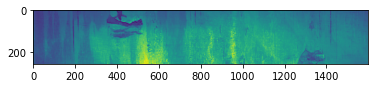

torch.Size([4, 256, 1600])
(256, 1600)


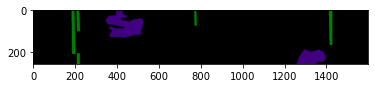

In [6]:
test_dataset = TestDataset(input_dir_Test, test_data, phase = 'test')

# Plotting images with labels
index = 1575

image, mask, fname = test_dataset.__getitem__(index) 
print(image.size())
print('filename : {}'.format(fname))
plt.imshow(image.to('cpu').detach().numpy().copy()[2])
plt.show()
print(mask.size())
mask_tp = (mask.to('cpu').detach().numpy().copy()[0]) + 2.*(mask.to('cpu').detach().numpy().copy()[1]) + 3.*(mask.to('cpu').detach().numpy().copy()[2]) + 4.*(mask.to('cpu').detach().numpy().copy()[3])
print(mask_tp.shape)
mask_plot = decode_segmap(mask_tp)
plt.imshow(mask_plot)
plt.show()

In [7]:
batch_size = 1

# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=6)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# data iterator
batch_iterator = iter(test_dataloader)  # batch data iterator
imgs, msks, fname = next(batch_iterator)  # 1 input batch 
print(imgs.size())

torch.Size([4, 3, 256, 1600])


In [8]:
"""
Define the required models accordingly
"""
from models.FPN import model as m #import all the required models accordingly ({ENEt, DANet, ENCNet, and etc})
from models.proposed_models.segformer import*
from models.proposed_models.Transformer_based import*
from models.proposed_models.CNN_based import*

# net = m # Use this for CNN-based models
#model = net
net = Transformer_based('MiT-B0') #Proposed hybrid netwrok of trasnformer-encoder (ResT) and CNN-decoder (UperNet)
# net = CNN_based('ConvNeXt-S') #CNN-based hybrid Networks
# net.init_pretrained('.../pretrained_weights/cpt/rest_small.pth')
model = net


In [9]:
# def count_parameters(x):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# count_parameters(model)

In [10]:
# from torchinfo import summary

# summary(model, (1,3,256,1600))

In [11]:
# #Model inference time, FPS
# test_model = model
# test_model.eval()
# device = torch.device("cuda")
# test_model.to(device)
# dummy_input = torch.randn(1, 3,256,1600, dtype=torch.float).to(device)
# # INIT LOGGERS
# starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
# repetitions = 1000
# timings=np.zeros((repetitions,1))
# #GPU-WARM-UP
# for _ in range(10):
#     _ = test_model(dummy_input)
# # MEASURE PERFORMANCE
# with torch.no_grad():
#     for rep in range(repetitions):
#         starter.record()
#         _ = test_model(dummy_input)
#         ender.record()
#         # WAIT FOR GPU SYNC
#         torch.cuda.synchronize()
#         curr_time = starter.elapsed_time(ender)
#         timings[rep] = curr_time
# mean_syn = np.sum(timings) / repetitions
# std_syn = np.std(timings)
# print('Average time per image in ms: ', mean_syn)
# print('Standard deviation of time:', std_syn)
# print('Frames per second (FPS): ', (1/(mean_syn/1000)))

In [12]:
'''Load the trained models accordingly'''
checkpoint_0 = torch.load(".../model_weights/SSDD-MiT-B0-Uperhead.pth") 
model.load_state_dict(checkpoint_0['state_dict']) 
print('Best result found at epoch of: ',checkpoint_0['epoch'])
print('state_dict loaded') 

Best result found at epoch of:  105
state_dict loaded


# Dice Coefficient

In [13]:
def dice_coeff(pred, mask):
    with torch.no_grad():
        batch_size = len(pred)
        pred = pred.view(batch_size, -1) # Flatten
        mask = mask.view(batch_size, -1)  # Flatten
        pred = (pred>0.5).float()
        mask = (mask>0.5).float()
        smooth = 0.0001
        intersection = (pred * mask).sum()
        dice = (2. * intersection +smooth ) / (pred.sum() + mask.sum() + smooth) 
        # intersection = ((pred + mask) == 0).sum()
        # dice_neg = (2. * intersection ) / ((pred == 0).sum() + (mask == 0).sum() + smooth)
        # dice = (dice_pos + dice_neg) / 2.0
        return dice #.item()

def IOU(pred, mask):
    with torch.no_grad():
        batch_size = len(pred)
        pred = pred.view(batch_size, -1) # Flatten
        mask = mask.view(batch_size, -1)  # Flatten
        pred = (pred>0.5).float()
        mask = (mask>0.5).float()
        smooth = 0.0001
        intersection = (pred * mask).sum()
        union = (pred.sum() + mask.sum()) - intersection
        iou = (intersection + smooth) / (union + smooth)
        # intersection = ((pred + mask) == 0).sum()
        # dice_neg = (2. * intersection ) / ((pred == 0).sum() + (mask == 0).sum() + smooth)
        # dice = (dice_pos + dice_neg) / 2.0
        return iou #.item()


def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric_dice (probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice # dice_neg, dice_pos, num_neg, num_pos

In [14]:
def class_dice(pred, mask):
    with torch.no_grad():
        batch_size = len(pred)
        # pred = pred.view(batch_size, -1) # Flatten
        # mask = mask.view(batch_size, -1)  # Flatten
        pred = (pred>0.5) 
        mask = (mask>0.5) 
        smooth = 0.0001
        
        intersection = (pred * mask).sum()
        dice = (2. * intersection + smooth) / (pred.sum() + mask.sum() + smooth) 
        # intersection = ((pred + mask) == 0).sum()
        # dice_neg = (2. * intersection ) / ((pred == 0).sum() + (mask == 0).sum() + smooth)
        # dice = (dice_pos + dice_neg) / 2.0
        return dice #.item()


def class_iou(pred, mask):
    with torch.no_grad():
        batch_size = len(pred)
        # pred = pred.view(batch_size, -1) # Flatten
        # mask = mask.view(batch_size, -1)  # Flatten
        pred = (pred>0.5) 
        mask = (mask>0.5) 
        smooth = 0.0001

        intersection = (pred * mask).sum()
        union = ((pred.sum() + mask.sum()) - intersection)
        iou = (intersection + smooth) / (union + smooth) 
        
        return iou #.item()

In [15]:
# Testing the model on test set
def model_test(model, dataloader):
    
    # GPU or CPU device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Available device：", device)

    # model to device
    model = model.to(device)

     
    torch.backends.cudnn.benchmark = True
    
    num_test_imgs = len(test_dataloader.dataset)
    batch_size = test_dataloader.batch_size
    
    epoch_acc = 0.0
    class_1_dice = 0.0
    class_2_dice = 0.0
    class_3_dice = 0.0
    class_4_dice = 0.0

    epoch_iou = 0.0
    class_1_iou = 0.0
    class_2_iou = 0.0
    class_3_iou = 0.0
    class_4_iou = 0.0
    # class_4_dice = 0.0
    # dice_mean = 0.0
    with torch.no_grad():
        for img, mask, fname in tqdm(test_dataloader):
            
            model.eval()
            # data to device
            img = img.to(device)
            mask = mask.to(device)
            output = model(img)
                
            prob = torch.sigmoid(output)
            prob = prob.to('cpu').detach()
            mask = mask.to('cpu').detach()
            # prob = torch.sigmoid(output)
        
            # Calculating class dice
            # prob_class = (prob>0.5).float()
            img = img.to('cpu').detach().numpy().copy()[0,0]
            msk_1 = mask.numpy().copy()[0,0]
            msk_2 = mask.numpy().copy()[0,1]
            msk_3 = mask.numpy().copy()[0,2]
            msk_4 = mask.numpy().copy()[0,3]
            # Use the post processing function
            
            prob_1 = prob.numpy().copy()[0,0]
            prob_2 = prob.numpy().copy()[0,1]
            prob_3 = prob.numpy().copy()[0,2]
            prob_4 = prob.numpy().copy()[0,3]
                          
            epoch_acc += metric_dice(prob, mask)
            class_1_dice += class_dice(prob_1, msk_1)
            class_2_dice += class_dice(prob_2, msk_2)
            class_3_dice += class_dice(prob_3, msk_3)
            class_4_dice += class_dice(prob_4, msk_4)
            
            # Calculating the iou and mean iou 
            epoch_iou += IOU(prob, mask)
            class_1_iou += class_iou(prob_1, msk_1)
            class_2_iou += class_iou(prob_2, msk_2)
            class_3_iou += class_iou(prob_3, msk_3)
            class_4_iou += class_iou(prob_4, msk_4)
            
    cl1_dice = class_1_dice / num_test_imgs * batch_size
    cl2_dice = class_2_dice / num_test_imgs * batch_size
    cl3_dice = class_3_dice / num_test_imgs * batch_size
    cl4_dice = class_4_dice / num_test_imgs * batch_size
    mDice = (cl1_dice + cl2_dice + cl3_dice + cl4_dice)/4

    cl1_mIoU = class_1_iou / num_test_imgs * batch_size
    cl2_mIoU = class_2_iou / num_test_imgs * batch_size
    cl3_mIoU = class_3_iou / num_test_imgs * batch_size
    cl4_mIoU = class_4_iou / num_test_imgs * batch_size
    mIoU = (cl1_mIoU + cl2_mIoU + cl3_mIoU + cl4_mIoU)/4    

    return cl1_dice, cl2_dice, cl3_dice, cl4_dice, mDice, cl1_mIoU, cl2_mIoU, cl3_mIoU, cl4_mIoU, mIoU

In [16]:
# Validating the model on the test set
cl1_dice, cl2_dice, cl3_dice, cl4_dice, mDice, cl1_mIoU, cl2_mIoU, cl3_mIoU, cl4_mIoU, mIoU   = model_test(model, test_dataloader)

Available device： cuda


  0%|          | 0/471 [00:00<?, ?it/s]

../SegFormer_New/upernet_head.py:69: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/aten/src/ATen/native/TensorIterator.cpp:924.)
  f = feature + F.interpolate(f, size=feature.shape[-2:], mode='bilinear', align_corners=False)
<ipython-input-13-56ecc1e5527d>:53: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  neg_index = torch.nonzero(t_sum == 0)


In [17]:
# import module
from tabulate import tabulate
 
# assign data
Results = [
    ["Score", cl1_dice*100, cl2_dice*100, cl3_dice*100, cl4_dice*100, mDice*100, cl1_mIoU*100, cl2_mIoU*100, cl3_mIoU*100, cl4_mIoU*100, mIoU*100]
]
 
# create header
head = ["Metrics", "cl1_dice", "cl2_dice", "cl3_dice", "cl4_dice", "mDice", "cl1_mIoU", "cl2_mIoU", "cl3_mIoU", "cl4_mIoU", "mIoU"]
 
# display table
print(tabulate(Results, headers=head, tablefmt="fancy_grid"))

╒═══════════╤════════════╤════════════╤════════════╤════════════╤═════════╤════════════╤════════════╤════════════╤════════════╤═════════╕
│ Metrics   │   cl1_dice │   cl2_dice │   cl3_dice │   cl4_dice │   mDice │   cl1_mIoU │   cl2_mIoU │   cl3_mIoU │   cl4_mIoU │    mIoU │
╞═══════════╪════════════╪════════════╪════════════╪════════════╪═════════╪════════════╪════════════╪════════════╪════════════╪═════════╡
│ Score     │    95.6458 │    98.3012 │    83.9127 │    98.4485 │  94.077 │    94.9093 │    98.0658 │    79.3098 │    97.8425 │ 92.5319 │
╘═══════════╧════════════╧════════════╧════════════╧════════════╧═════════╧════════════╧════════════╧════════════╧════════════╧═════════╛


In [18]:
# Show and Save predicted image
def predict_show(index, test_dataloader, model, spath=None):
    
    # Select available device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Available device：", device)

    # model to device
    model = model.to(device)

   
    torch.backends.cudnn.benchmark = True
    
    with torch.no_grad():
        
        model.eval()
        
        image, mask, fname = test_dataloader.dataset.__getitem__(index)
        
        img = image.unsqueeze(0)
        msk = mask.unsqueeze(0)
        
        # data to device
        img = img.to(device)
            
        output = model(img)
            
        prob = torch.sigmoid(output)
        prob = (prob>0.5).float()
        # print(prob.shape)
        # print(fname)
        
        img = img.to('cpu').detach().numpy().copy()[0,0]
        msk_1 = msk.to('cpu').detach().numpy().copy()[0,0]
        # msk_1 = cv2.resize(msk_1, (200, 200), interpolation=cv2.INTER_NEAREST)

        msk_2 = msk.to('cpu').detach().numpy().copy()[0,1]
        msk_2 = 2.*msk_2
        # msk_2 = cv2.resize(msk_2, (200, 200), interpolation=cv2.INTER_NEAREST)

        msk_3 = msk.to('cpu').detach().numpy().copy()[0,2]
        msk_3 = 3.*msk_3
        # msk_3 = cv2.resize(msk_3, (200, 200), interpolation=cv2.INTER_NEAREST)


        msk_4 = msk.to('cpu').detach().numpy().copy()[0,3]
        msk_4 = 4.*msk_4
        # msk_4 = cv2.resize(msk_4, (200, 200), interpolation=cv2.INTER_NEAREST)

        prob_1 = prob.to('cpu').detach().numpy().copy()[0,0]
        # prob_1 = cv2.resize(prob_1, (200, 200), interpolation=cv2.INTER_NEAREST)

        prob_2 = prob.to('cpu').detach().numpy().copy()[0,1]
        prob_2 = 2.*prob_2
        # prob_2 = cv2.resize(prob_2, (200, 200), interpolation=cv2.INTER_NEAREST)

        prob_3 = prob.to('cpu').detach().numpy().copy()[0,2]
        prob_3 = 3.*prob_3
        # prob_3 = cv2.resize(prob_3, (200, 200), interpolation=cv2.INTER_NEAREST)

        prob_4 = prob.to('cpu').detach().numpy().copy()[0,3]
        prob_4 = 4.*prob_4
        # prob_4 = cv2.resize(prob_3, (200, 200), interpolation=cv2.INTER_NEAREST)

        msk_tot = msk_1 + msk_2 + msk_3 + msk_4
        prob_tot = prob_1 + prob_2 + prob_3 + prob_4

        #false positive and false negative mask
        fn_msk = msk_tot - prob_tot
        fp_msk = prob_tot - msk_tot


        #COnvert to rgb

        msk_tot = decode_segmap(msk_tot)
        prob_tot = decode_segmap(prob_tot)
        fn_msk = decode_segmap(fn_msk)
        fp_msk = decode_segmap(fp_msk)
        
                    
        print("Plotting the image with predicted mask")
        print("filename : {}".format(fname))
        plt.imshow(cv2.resize(img, (1600, 256), interpolation=cv2.INTER_NEAREST))
        plt.xticks([])
        plt.yticks([])
        plt.show()

        print()


        fig = plt.figure(figsize=(25, 15))
        #Axis 1
        ax1 = fig.add_subplot(1, 4, 1)
        ax1.set_title("GT mask")
        # ax1.set_xlabel('GT mask_1')
        ax1.set_ylabel('')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.imshow(msk_tot)

        #Axis 2
         
        ax2 = fig.add_subplot(1, 4, 2)
        ax2.set_title("Predicted mask")
        # ax2.set_xlabel('predicted mask_1')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.imshow(prob_tot)
        

        #Axis 3
         
        ax3 = fig.add_subplot(1, 4, 3)
        ax3.set_title("False positive")
        # ax3.set_xlabel('GT mask_2')
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.imshow(fp_msk)

        #Axis 4
         
        ax4 = fig.add_subplot(1, 4, 4)
        ax4.set_title("False negative")
        # ax4.set_xlabel('predicted mask_2')
        ax4.set_xticks([])
        ax4.set_yticks([])
        ax4.imshow(fn_msk)



Available device： cuda
Plotting the image with predicted mask
filename : d2a854e69.jpg


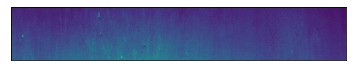

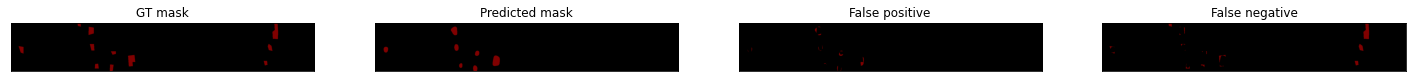

In [19]:
index =1594
predict_show(index, test_dataloader,model)